In [3]:
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd

# Load author embeddings
print("Loading author embeddings...")
with open('multi_paper_author_embeddings.pkl', 'rb') as f:
    author_data = pickle.load(f)

# Extract authors and create ordered list for consistent indexing
authors = list(author_data.keys())
print(f"Loaded embeddings for {len(authors)} authors")

# Create embedding matrix efficiently
print("Creating embedding matrix...")
embedding_matrix = np.stack([
    author_data[author]['embedding'] 
    for author in authors
])

# Calculate similarity matrix using efficient matrix multiplication
print("Calculating similarity matrix...")
similarity_matrix = np.dot(embedding_matrix, embedding_matrix.T)

# Create a DataFrame for better visualization
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=authors,
    columns=authors
)

# Function to plot similarity matrix for top N authors
def plot_top_authors_similarity(N=50, figsize=(15, 15)):
    """Plot similarity matrix for top N authors by paper count."""
    # Get top N authors by paper count
    top_authors = sorted(
        authors,
        key=lambda x: author_data[x]['paper_count'],
        reverse=True
    )[:N]
    
    # Extract submatrix for top authors
    top_similarity = similarity_df.loc[top_authors, top_authors]
    
    # Create labels with paper counts
    labels = [
        f"{author} ({author_data[author]['paper_count']})"
        for author in top_authors
    ]
    
    # Plot heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(
        top_similarity,
        xticklabels=labels,
        yticklabels=labels,
        cmap='coolwarm',
        center=0,
        vmin=-1,
        vmax=1
    )
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.title(f'Author Similarity Matrix (Top {N} Authors by Paper Count)')
    plt.tight_layout()
    plt.show()

# Function to find most similar authors
def find_similar_authors(author_name, top_k=5):
    """Find the most similar authors to a given author."""
    if author_name not in authors:
        print(f"Author '{author_name}' not found in database.")
        return
    
    # Get similarities for the author
    similarities = similarity_df[author_name]
    
    # Sort similarities excluding the author themselves
    similar_authors = similarities.drop(author_name).sort_values(ascending=False)
    
    print(f"\nMost similar authors to {author_name}:")
    print(f"Number of papers: {author_data[author_name]['paper_count']}")
    print("\nPapers:")
    for paper in author_data[author_name]['papers']:
        print(f"- {paper['title']}")
    
    print("\nSimilar authors:")
    for author, similarity in similar_authors[:top_k].items():
        print(f"\n{author} (similarity: {similarity:.3f})")
        print(f"Number of papers: {author_data[author]['paper_count']}")
        print("Papers:")
        for paper in author_data[author]['papers']:
            print(f"- {paper['title']}")

Loading author embeddings...
Loaded embeddings for 3735 authors
Creating embedding matrix...
Calculating similarity matrix...



Visualizing similarity matrix for top authors...


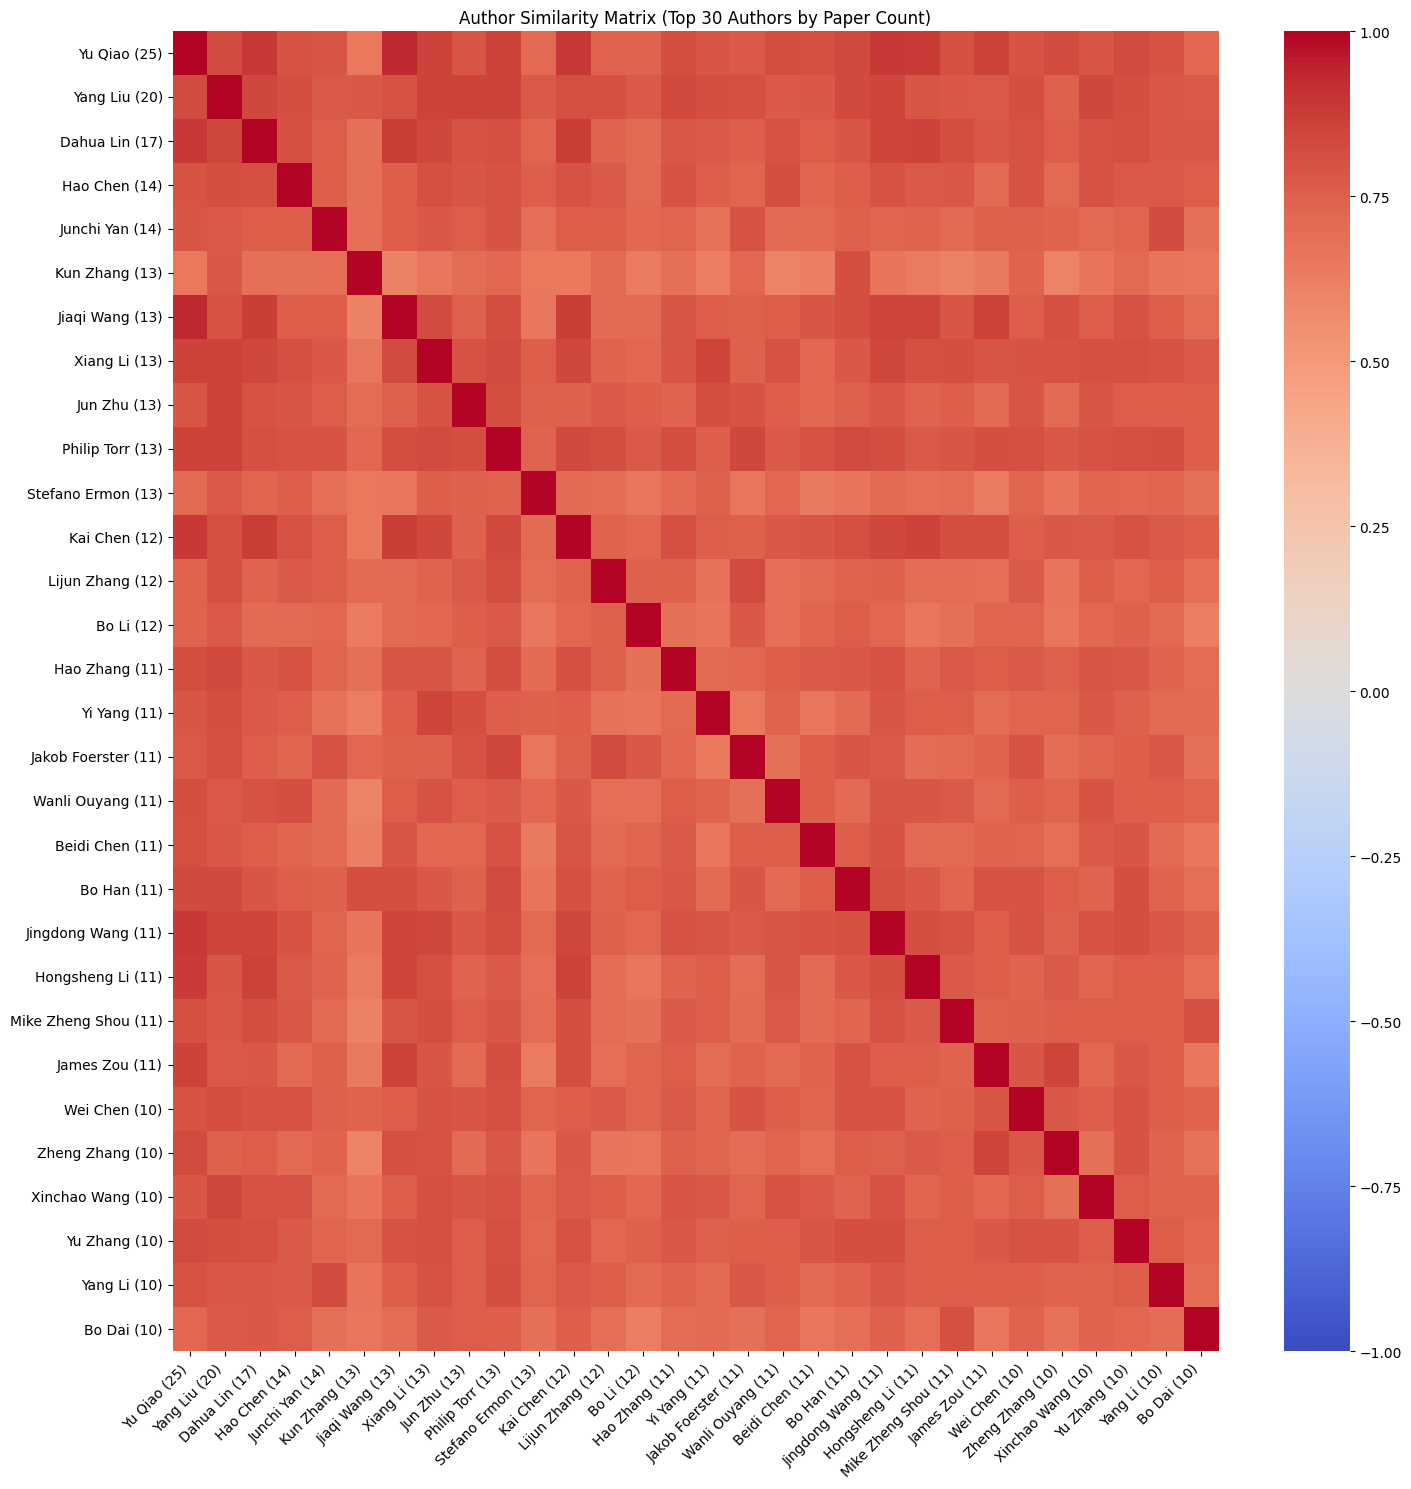


Finding similar authors example...

Most similar authors to Karthikeyan Shanmugam:
Number of papers: 4

Papers:
- Causal Bandits for Linear Structural Equation Models
- Sample Complexity of Interventional Causal Representation Learning
- Linear Causal Representation Learning from Unknown Multi-node Interventions
- Time-Reversal Provides Unsupervised Feedback to LLMs

Similar authors:

Arun Suggala (similarity: 0.905)
Number of papers: 2
Papers:
- Near-Optimal Streaming Heavy-Tailed Statistical Estimation with Clipped SGD
- Time-Reversal Provides Unsupervised Feedback to LLMs

Prateek Jain (similarity: 0.890)
Number of papers: 3
Papers:
- Mixture of Nested Experts: Adaptive Processing of Visual Tokens
- MatFormer: Nested Transformer for Elastic Inference
- Time-Reversal Provides Unsupervised Feedback to LLMs

Bo Han (similarity: 0.786)
Number of papers: 11
Papers:
- FuseFL: One-Shot Federated Learning through the Lens of Causality with Progressive Model Fusion
- Mind the Gap Between Pr

In [4]:
# Example usage:
print("\nVisualizing similarity matrix for top authors...")
plot_top_authors_similarity(N=30)

print("\nFinding similar authors example...")
# Replace with an actual author name from your dataset
example_author = authors[0]
find_similar_authors(example_author, top_k=3)

# Optional: Save similarity matrix for future use
print("\nSaving similarity matrix...")
similarity_df.to_pickle('author_similarity_matrix.pkl')

In [14]:
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import json
from collections import defaultdict

# Load author embeddings
print("Loading author embeddings...")
with open('multi_paper_author_embeddings.pkl', 'rb') as f:
    author_data = pickle.load(f)

# Load original sessions data
print("Loading sessions data...")
with open('neurips_sessions.json', 'r') as f:
    sessions_data = json.load(f)

# Extract authors and create ordered list for consistent indexing
authors = list(author_data.keys())
print(f"Loaded embeddings for {len(authors)} authors")

# Create embedding matrix efficiently
print("Creating embedding matrix...")
embedding_matrix = np.stack([
    author_data[author]['embedding'] 
    for author in authors
])

# Calculate similarity matrix using efficient matrix multiplication
print("Calculating similarity matrix...")
similarity_matrix = np.dot(embedding_matrix, embedding_matrix.T)

# Create a DataFrame for better visualization
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=authors,
    columns=authors
)

def build_coauthor_map() -> dict:
    """Build a mapping of authors to their co-authors across all papers."""
    coauthor_map = defaultdict(set)
    
    for session_data in sessions_data.values():
        for poster in session_data['posters']:
            authors_set = set(poster['authors'])
            for author in poster['authors']:
                coauthor_map[author].update(authors_set - {author})
    
    return coauthor_map

# Build coauthor map once
coauthor_map = build_coauthor_map()

def analyze_author_similarities(author_name: str, top_k: int = 5):
    """Analyze author similarities both including and excluding co-authors."""
    if author_name not in authors:
        print(f"Author '{author_name}' not found in multi-paper authors database.")
        return
    
    if author_name not in coauthor_map:
        print(f"Author '{author_name}' not found in sessions data.")
        return
    
    # Get all co-authors for the given author
    coauthors = coauthor_map[author_name]
    
    # Get similarities for the author
    similarities = similarity_df[author_name]
    
    # Calculate both filtered and unfiltered similarities
    # Unfiltered: exclude only the author themselves
    unfiltered_similarities = similarities.drop(author_name).sort_values(ascending=False)
    
    # Filtered: exclude co-authors and the author themselves
    valid_authors = set(authors) - coauthors - {author_name}
    filtered_similarities = similarities[list(valid_authors)].sort_values(ascending=False)
    
    # Print author information
    print(f"\nAnalysis for {author_name}:")
    print(f"Number of papers: {author_data[author_name]['paper_count']}")
    print(f"Number of co-authors: {len(coauthors)}")
    
    print("\nAuthor's papers:")
    for paper in author_data[author_name]['papers']:
        print(f"- {paper['title']}")
    
    # Print most similar authors (including co-authors)
    print("\nMost similar authors (including co-authors):")
    for author, similarity in unfiltered_similarities[:top_k].items():
        is_coauthor = author in coauthors
        print(f"\n{author} (similarity: {similarity:.3f}){' [Co-author]' if is_coauthor else ''}")
        print(f"Number of papers: {author_data[author]['paper_count']}")
        print("Papers:")
        for paper in author_data[author]['papers']:
            print(f"- {paper['title']}")
    
    # Print most similar authors (excluding co-authors)
    print("\nMost similar authors (excluding co-authors):")
    for author, similarity in filtered_similarities[:top_k].items():
        print(f"\n{author} (similarity: {similarity:.3f})")
        print(f"Number of papers: {author_data[author]['paper_count']}")
        print("Papers:")
        for paper in author_data[author]['papers']:
            print(f"- {paper['title']}")

# Example usage:
print("\nAnalyzing author similarities...")
# Replace with an actual author name from your dataset
example_author = 'Philip Torr'
analyze_author_similarities(example_author, top_k=3)

Loading author embeddings...
Loading sessions data...
Loaded embeddings for 3735 authors
Creating embedding matrix...
Calculating similarity matrix...

Analyzing author similarities...

Analysis for Philip Torr:
Number of papers: 13
Number of co-authors: 68

Author's papers:
- What Makes and Breaks Safety Fine-tuning? A Mechanistic Study
- Can Large Language Model Agents Simulate Human Trust Behavior?
- No "Zero-Shot" Without Exponential Data: Pretraining Concept Frequency Determines Multimodal Model Performance
- Label Alignment Regularization for Distribution Shift
- Secret Collusion among AI Agents: Multi-Agent Deception via Steganography
- Random Representations Outperform Online Continually Learned Representations
- Direct3D: Scalable Image-to-3D Generation via 3D Latent Diffusion Transformer
- Universal In-Context Approximation By Prompting Fully Recurrent Models
- Hidden in Plain Sight: Evaluating Abstract Shape Recognition in Vision-Language Models
- Set-based Neural Network En

In [24]:
# Create a mask for co-authors
coauthor_mask = np.zeros_like(similarity_matrix, dtype=bool)
for i, author1 in enumerate(authors):
    for j, author2 in enumerate(authors):
        if author2 in coauthor_map[author1]:
            coauthor_mask[i, j] = True

# Create copy of similarity matrix and mask out co-authors and self-similarities
masked_similarities = similarity_matrix.copy()
masked_similarities[coauthor_mask] = -np.inf  # Mask co-authors
np.fill_diagonal(masked_similarities, -np.inf)  # Mask self-similarities

# Find top pairs
top_k = 10
pairs = []

# Get indices of top pairs
for _ in range(top_k):
    max_idx = np.unravel_index(np.argmax(masked_similarities), masked_similarities.shape)
    similarity = similarity_matrix[max_idx]
    pairs.append((authors[max_idx[0]], authors[max_idx[1]], similarity))
    # Mask this pair so we don't select it again
    masked_similarities[max_idx[0], max_idx[1]] = -np.inf
    masked_similarities[max_idx[1], max_idx[0]] = -np.inf

print(f"\nTop {top_k} most similar author pairs (excluding co-authors):")
print("-" * 80)

for i, (author1, author2, similarity) in enumerate(pairs, 1):
    print(f"\n{i}. Similarity Score: {similarity:.3f}")
    
    # Author 1 details
    print(f"Author: {author1}")
    print(f"Number of papers: {author_data[author1]['paper_count']}")
    for paper in author_data[author1]['papers'][:2]:  # Show up to 2 papers
        print(f"- {paper['title']}")
    
    # Author 2 details
    print(f"\nAuthor: {author2}")
    print(f"Number of papers: {author_data[author2]['paper_count']}")
    for paper in author_data[author2]['papers'][:2]:  # Show up to 2 papers
        print(f"- {paper['title']}")
    
    print("-" * 80)


Top 10 most similar author pairs (excluding co-authors):
--------------------------------------------------------------------------------

1. Similarity Score: 0.899
Author: Ping Luo
Number of papers: 9
- ConvBench: A Multi-Turn Conversation Evaluation Benchmark with Hierarchical Ablation Capability for Large Vision-Language Models
- VisionLLM v2: An End-to-End Generalist Multimodal Large Language Model for Hundreds of Vision-Language Tasks

Author: Jiaqi Wang
Number of papers: 13
- MMLONGBENCH-DOC: Benchmarking Long-context Document Understanding with Visualizations
- FEDMEKI: A Benchmark for Scaling Medical Foundation Models via Federated Knowledge Injection
--------------------------------------------------------------------------------

2. Similarity Score: 0.885
Author: Yu Qiao
Number of papers: 25
- ConvBench: A Multi-Turn Conversation Evaluation Benchmark with Hierarchical Ablation Capability for Large Vision-Language Models
- MLLMGuard: A Multi-dimensional Safety Evaluation Su

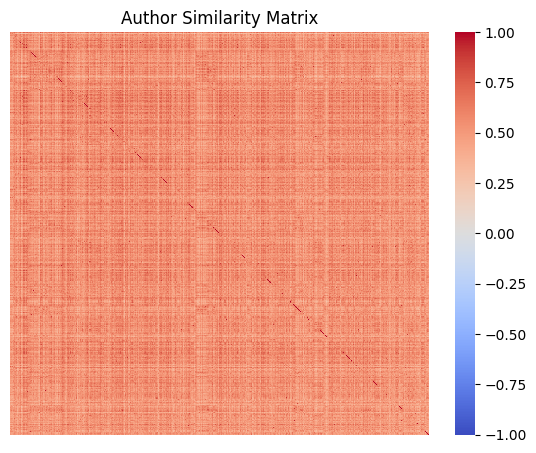

In [20]:
# Visualise whole similarity matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    similarity_matrix,
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1
)
plt.title('Author Similarity Matrix')
plt.tight_layout()
# Remove xticks and yticks
plt.xticks([])
plt.yticks([])
plt.show()